In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
import xgboost as xgb
from sklearn.model_selection import cross_val_score
# from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform as sp_uniform
from scipy.stats import randint as sp_randint
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import time

## This is a classification task for "Pima diabetes" dataset where the target attribute is 'Outcome'

In [2]:
# Read in CSV data-
pima_data = pd.read_csv("Pima_Diabetes_Data.csv")

In [3]:
# Dimension of data-
pima_data.shape

(768, 9)

In [4]:
# Get datatypes for all attributes in dataset-
pima_data.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [5]:
# Check for missing values (if any)-
pima_data.isnull().values.any()

False

In [6]:
# Get distribution of target variable 'Outcome'-
pima_data['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

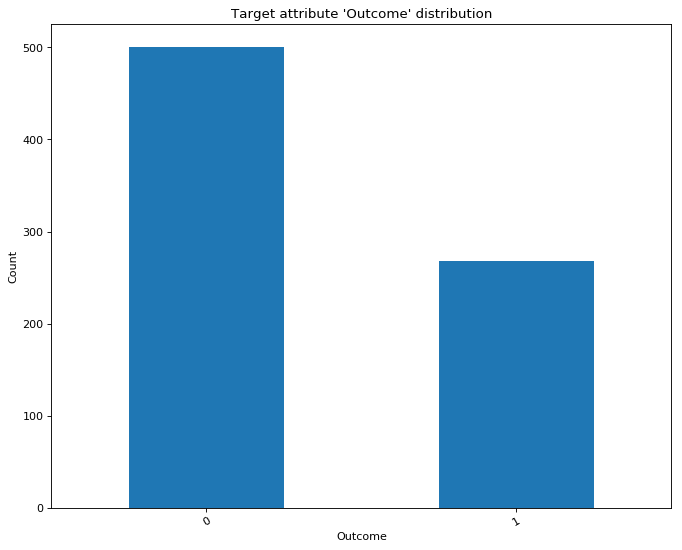

In [7]:
# Visualize distribution of target attribute 'Outcome'-
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')

pima_data['Outcome'].value_counts().plot(kind = 'bar')

plt.xlabel("Outcome")
plt.ylabel("Count")
plt.title("Target attribute 'Outcome' distribution")
plt.xticks(rotation = 30)
plt.show()


# NOTE: from the plot, we can see that the distribution is skewed for class 0!

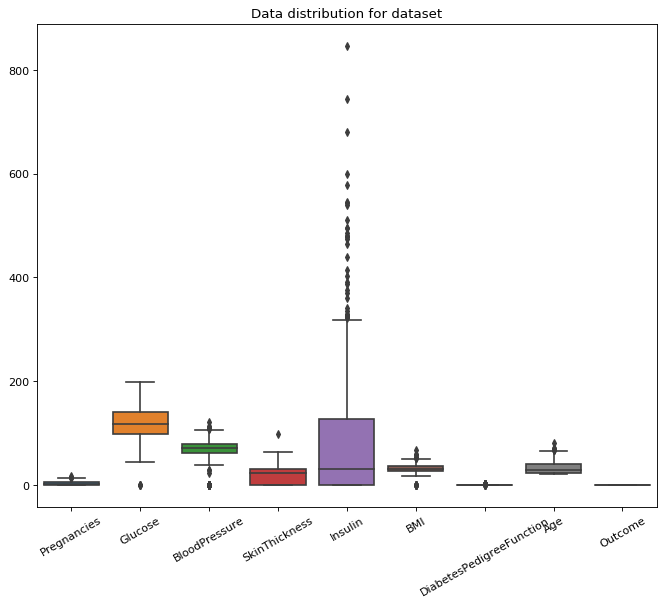

In [8]:
# Visualization distribution of attributes in dataset using boxplots-
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')

sns.boxplot(data=pima_data)

plt.title("Data distribution for dataset")
plt.xticks(rotation = 30)
plt.show()

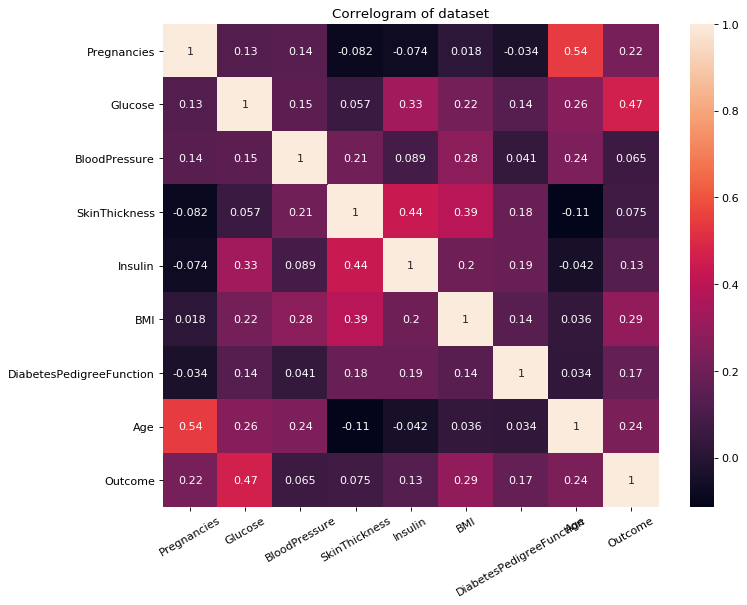

In [9]:
# Visualize correlation in dataset using heatmap-
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')

# Compute correlation matrix of dataset-
pima_data_corr = pima_data.corr()

sns.heatmap(data=pima_data_corr, annot=True)

plt.title("Correlogram of dataset")
plt.xticks(rotation = 30)
plt.show()

In [10]:
# Split dataset into features (X) and label (y)-
X = pima_data.drop('Outcome', axis = 1)
y = pima_data['Outcome']

# Convert all numeric values to float-
X = X.values.astype("float")

# Convert 'X' from numpy array to pandas DataFrame-
X = pd.DataFrame(X, columns=pima_data.columns.tolist()[:-1])

In [11]:
# Normalize/Scale dataset-
# mm_scaler = MinMaxScaler()
rb_scaler = RobustScaler()

# X_scaled = mm_scaler.fit_transform(X)
X_scaled = rb_scaler.fit_transform(X)

# Convert 'X_scaled' from numpy array to pandas DataFrame-
X_scaled = pd.DataFrame(X_scaled, columns=X.columns.tolist())

In [12]:
# Divide attributes & labels into training & testing sets-
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.30, stratify = y)

print("\nDimensions of training and testing sets are:")
print("X_train = {0}, y_train = {1}, X_test = {2} and y_test = {3}\n\n".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))


Dimensions of training and testing sets are:
X_train = (537, 8), y_train = (537,), X_test = (231, 8) and y_test = (231,)




In [13]:
# Transform our data to 'DMatrix'
D_train = xgb.DMatrix(data = X_train, feature_names = X_train.columns, label = y_train.values)
D_test = xgb.DMatrix(data = X_test, feature_names = X_test.columns, label = y_test.values)

In [21]:
# XGBoost classifier-

# Parameters to be used in training model-
params = {
    'learning_rate': 0.1,
    'max_depth': 3,
    'objective': 'binary:logistic'
}

# Number of training iterations to be performed-
steps = 100

# Instantiate a base XGBoost classifier-
# xgb_clf = xgb.XGBClassifier(params)

# Train XGBoost classifier with parameters from above-
xgb_clf = xgb.train(params, D_train, steps)

In [22]:
# Make predictions using trained model-
y_pred = xgb_clf.predict(D_test)

# Convert 'y_pred' to either 0 or 1-
y_pred_conv = [0 if x < 0.5 else 1 for x in y_pred]

In [23]:
# Get model metrics-
accuracy = accuracy_score(y_test, y_pred_conv)
precision = precision_score(y_test, y_pred_conv)
recall = recall_score(y_test, y_pred_conv)
f1score = f1_score(y_test, y_pred_conv)

print("\nXGBoost classifier base model metrics are:")
print("Accuracy = {0:.4f}, Precision = {1:.4f}, Recall = {2:.4f} & F1-Score = {3:.4f}".format(accuracy, precision, recall, f1score))


XGBoost classifier base model metrics are:
Accuracy = 0.7662, Precision = 0.6588, Recall = 0.6914 & F1-Score = 0.6747


In [26]:
# Perform 5-fold Cross-Validation-
xgb_clf_cvs = xgb.cv(params = params, dtrain  = D_train, num_boost_round = 50, nfold=5, stratified=True)

In [27]:
xgb_clf_cvs

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.229057,0.015926,0.290654,0.038086
1,0.215568,0.019665,0.290654,0.035227
2,0.201122,0.008766,0.271980,0.030575
3,0.202058,0.010527,0.273867,0.029714
4,0.200196,0.012219,0.277605,0.033536
5,0.194140,0.011659,0.277605,0.033536
6,0.193211,0.011916,0.277605,0.033536
7,0.189014,0.011468,0.273849,0.036921
8,0.182965,0.010756,0.281343,0.035653
9,0.180640,0.014852,0.283229,0.041305


### Observation of using 5-fold Cross-Validation
We can see that the base model of XGBoost classifier is overfitting to training dataset. Because,
'test-error-mean' isn't reducing as compared to 'train-error-mean'

Try reducing overfitting of model!

## Perform hyper parameter tuning

### Using 'hyperopt'

In [46]:
# Parameters to be used-
param_space = {
    # 'learning_rate': hp.uniform('learning_rate', 0.05, 0.4),
    # 'objective': ['binary:logistic'],
    'learning_rate': hp.quniform('learning_rate', 0.05, 0.4, 0.2),
    'max_depth': hp.quniform('max_depth', 2, 12, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.3, 0.9),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
    'n_estimators': hp.quniform('n_estimators', 50, 400, 50)

}

In [47]:
def accuracy_model(params):
    # Train a XGBoost classifier using 'params'-
    params = {
            'n_estimators': int(params['n_estimators']),
            # 'min_data_in_leaf': int(params['min_data_in_leaf']),
            'max_depth': int(params['max_depth']),
            'min_child_weight': int(params['min_child_weight']),
            'subsample': '{0:.4f}'.format(params['subsample']),
            'colsample_bytree': '{0:.4f}'.format(params['colsample_bytree']),
            'learning_rate': '{0:.4f}'.format(params['learning_rate']),
            # 'objective': ['binary:logistic']

    }

    # Train XGBoost classifier using 'params'-
    xgb_clf = xgb.XGBClassifier(**params)

    # Use 5-fold CV to get mean of cross validated score(s)-
    return cross_val_score(xgb_clf, X_train, y_train, cv = 5).mean()


In [56]:
# Keep track of 'best' accuracy score found so far-
best = 0


def get_best_accuracy(params):
    '''
    Function to find best 'accuracy' found so far for a given set of 'params' parameters
    '''
    global best
    accuracy = accuracy_model(params)

    if accuracy > best:
        best = accuracy

    print("\nNew best accuracy = {0:.4f} & parameters: {1}".format(best, params))

    return {'loss': (1 - accuracy), 'status': STATUS_OK}


In [57]:
start_time = time.time()

In [58]:
trials = Trials()

best = fmin(get_best_accuracy, param_space, algo = tpe.suggest, max_evals=100, trials = trials)

print("\n\nBest parameters obtained using 'hyperopt' for XGBoost classifier are:\n{0}\n\n".format(best))


New best accuracy = 0.7039 & parameters: {'colsample_bytree': 0.841595429642694, 'learning_rate': 0.4, 'max_depth': 5.0, 'min_child_weight': 5.0, 'n_estimators': 350.0, 'subsample': 0.5493841453731017}

New best accuracy = 0.7319 & parameters: {'colsample_bytree': 0.8704801783950313, 'learning_rate': 0.4, 'max_depth': 11.0, 'min_child_weight': 1.0, 'n_estimators': 250.0, 'subsample': 0.6368113199821297}

New best accuracy = 0.7356 & parameters: {'colsample_bytree': 0.6836600476013674, 'learning_rate': 0.2, 'max_depth': 8.0, 'min_child_weight': 2.0, 'n_estimators': 100.0, 'subsample': 0.7555030082912528}

New best accuracy = 0.7356 & parameters: {'colsample_bytree': 0.3816547518565897, 'learning_rate': 0.0, 'max_depth': 2.0, 'min_child_weight': 8.0, 'n_estimators': 400.0, 'subsample': 0.5275315000772405}

New best accuracy = 0.7356 & parameters: {'colsample_bytree': 0.3987694555136404, 'learning_rate': 0.0, 'max_depth': 12.0, 'min_child_weight': 9.0, 'n_estimators': 150.0, 'subsample':

In [59]:
end_time = time.time()
print("\n\nTotal time taken by hyperopt for XGBoost classifier = {0:.4f}\n\n\n".format(end_time - start_time))



Total time taken by hyperopt for XGBoost classifier = 38.7773





### Using RandomizedSearchCV

In [70]:
# Parameters to be used by RandomizedSearchCV using parameters from above-
rs_params = {
    'objective': ['binary:logistic'],
    'learning_rate': sp_uniform(0.1, 0.2),
    'colsample_bytree': sp_uniform(0.4, 0.3),
    'max_depth': sp_randint(7, 10),
    'min_child_weight': sp_randint(7, 10),
    'n_estimators': sp_randint(200, 300),
    'subsample': sp_uniform(0.6, 0.2)
}

In [71]:
start_time = time.time()

In [72]:
# Initialize a RandomizedSearchCV object using 10-fold CV-
rs_cv = RandomizedSearchCV(estimator=xgb.XGBClassifier(), param_distributions=rs_params, n_iter=100, cv = 10)

In [73]:
# Train RandomizedSearchCV object on training data-
rs_cv.fit(X_train, y_train)

/home/arjun/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scal...
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2c68814128>,
                                        'n_estimators': <scipy.stats._distn_infrastructur

In [74]:
print("\n\nBest parameters found using RandomizedSearchCV are\n{0}".format(rs_cv.best_params_))



Best parameters found using RandomizedSearchCV are
{'colsample_bytree': 0.6724745137703737, 'learning_rate': 0.13006995137427407, 'max_depth': 7, 'min_child_weight': 8, 'n_estimators': 284, 'objective': 'binary:logistic', 'subsample': 0.7506172521757468}


In [75]:
end_time = time.time()

In [76]:
print("\n\nTraining time of RandomizedSearchCV = {0:.4f}\n\n".format(end_time - start_time))



Training time of RandomizedSearchCV = 74.4497




In [78]:
# Make predictions using RandomizedSearchCV-
y_pred_rs = rs_cv.predict(X_test)

In [79]:
# Get model metrics-
accuracy_rs = accuracy_score(y_test, y_pred_rs)
precision_rs = precision_score(y_test, y_pred_rs)
recall_rs = recall_score(y_test, y_pred_rs)
f1score_rs = f1_score(y_test, y_pred_rs)

print("\nXGBoost classifier RandomizedSearchCV model metrics are:")
print("Accuracy = {0:.4f}, Precision = {1:.4f}, Recall = {2:.4f} & F1-Score = {3:.4f}".format(accuracy_rs, precision_rs, recall_rs, f1score_rs))


XGBoost classifier RandomizedSearchCV model metrics are:
Accuracy = 0.7489, Precision = 0.6575, Recall = 0.5926 & F1-Score = 0.6234


### Using GidSearchCV to fine tune parameters from above

In [87]:
start_time = time.time()

In [88]:
# Parameters to be used for GridSearchCV-
gs_params = {
    'objective':['binary:logistic'],
    'learning_rate': [0.1, 0.13, 0.15],
    'colsample_bytree': [0.6, 0.67, 0.7],
    'max_depth': [6, 7, 8],
    'min_child_weight': [7, 8, 9],
    'n_estimators': [280, 285, 290],
    'subsample': [0.7, 0.75, 0.8]
}

In [89]:
# Initialize a GridSearchCV object using 10-fold CV-
gs_cv = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=gs_params, cv = 10)

In [90]:
# Train GridSearchCV object on training data-
gs_cv.fit(X_train, y_train)

/home/arjun/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bytree=1,
                                     gamma=0, learning_rate=0.1,
                                     max_delta_step=0, max_depth=3,
                                     min_child_weight=1, missing=None,
                                     n_estimators=100, n_jobs=1, nthread=None,
                                     objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_...None, silent=True,
                                     subsample=1),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 0.67, 0.7],
                         'learning_rate': [0.1, 0.13, 0.15],
                         'max_depth': [6, 7, 8], 'min_child_weight': [7, 8, 9],
       

In [91]:
print("\n\nBest parameters found using GridSearchCV are\n{0}\n\n".format(gs_cv.best_params_))

print("Best score achieved using GridSearchCV = {0:.4f}\n\n".format(gs_cv.best_score_))



Best parameters found using GridSearchCV are
{'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 8, 'n_estimators': 285, 'objective': 'binary:logistic', 'subsample': 0.75}


Best score achieved using GridSearchCV = 0.7691




In [92]:
end_time = time.time()
print("\n\nTraining time of GridSearchCV = {0:.4f}\n\n".format(end_time - start_time))



Training time of GridSearchCV = 669.9315




### Finally, train a "best" XGBoost classifier using parameters found from 'GridSearchCV' from above

In [95]:
'''
# Initialize 'best' XGBoost classifier-
best_xgb_clf = xgb.XGBClassifier(
    objective = 'binary:logistic',
    learning_rate = ,
    colsample_bytree = ,
    max_depth = ,
    min_child_weight = ,
    n_estimators = ,
    subsample = 
)
'''

# Parameters to be used for 'best' XGBoost classifier-
best_params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.1,
    'colsample_bytree': 0.6,
    'max_depth': 6,
    'min_child_weight': 8,
    'n_estimators': 285,
    'subsample': 0.75
}

# Number of training iterations to be performed-
steps = 20

In [96]:
# Train best XGBoost model on training data-
# best_xgb_clf.fit(X_train, y_train)

# Instantiate and train XGBoost classifier-
best_xgb_clf = xgb.train(best_params, D_train)
# best_xgb_clf = xgb.train(best_params, D_train, steps)

In [97]:
# Make prediction using trained model-
# y_pred_best = best_xgb_clf.predict(X_test)
y_pred_best = xgb_clf.predict(D_test)

# Convert 'y_pred' to either 0 or 1-
y_pred_best_conv = [0 if x < 0.5 else 1 for x in y_pred_best]

In [98]:
accuracy_best = accuracy_score(y_test, y_pred_best_conv)
precision_best = precision_score(y_test, y_pred_best_conv, average='macro')
recall_best = recall_score(y_test, y_pred_best_conv, average = 'macro')

print("\nModel metrics of 'best' XGBoost classifier are:")
print("Accuracy = {0:.4f}, Precision = {1:.4f} & Recall = {2:.4f}\n".format(accuracy_best, precision_best, recall_best))



Model metrics of 'best' XGBoost classifier are:
Accuracy = 0.7576, Precision = 0.7407 & Recall = 0.7054



In [102]:
'''
We will use AUC (Area Under Curve) as the evaluation metric.
Our target value is binary so it’s a binary classification problem.
AUC is a good way for evaluation for this type of problems.
'''
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_best_conv)
roc_auc = auc(false_positive_rate, true_positive_rate)

print("\nAUC score for 'best' XGBoost classifier = {0:.4f}\n\n".format(roc_auc))


AUC score for 'best' XGBoost classifier = 0.7054




In [103]:
print("\nConfusion Matrix of 'best' model:\n{0}\n\n".format(confusion_matrix(y_test, y_pred_best_conv)))


Confusion Matrix of 'best' model:
[[132  18]
 [ 38  43]]




### Final Observations:

We can see that the accuracy of the model hasn't really improved from approximately 75.76%.
However, precision improved from 70.49% (for base model) to 74.07% (for 'best' model) and recall improved
from 53.09% (for base model) to 70.54% (for best model)

Also, from the confusion matrix, we can see that the model is confused for class 1 as the dataset is skewed
for class 0 as the visualization for class distribution shows in the visualization from above.

In [105]:
'''
# save 'model' to disk-
filename = 'Final_Pima_Diabetes-XGBoost_Classifier.sav'
joblib.dump(best_xgb_clf, filename)
'''

'''
# load the model from disk-
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, Y_test)

print(result)
'''

'\n# load the model from disk-\nloaded_model = joblib.load(filename)\nresult = loaded_model.score(X_test, Y_test)\n\nprint(result)\n'